## Optimal Nonparametric Density Estimation with `condensier` and `sl3`

## Lab 09 for PH 290: Targeted Learning in Biomedical Big Data

### Author: [Nima Hejazi](https://nimahejazi.org)

### Date: 14 March 2018

# I. Nonparametric Density Estimation

For a moment, we will go back to simple data structures: we have observations which are realizations of univariate random variables,
$$X_1, \ldots, X_n \sim F,$$
where $F$ denotes an unknown cumulative distribution function (CDF). The goal is to estimate the distribution $F$. In particular, we are interested in estimating the density $f = F′$ , assuming that it exists.

### Histograms

The histogram is the oldest and most popular density estimator. We need to specify an "origin" $x_0$ and the class width $h$ for the specifications of the intervals:
$$I_j =(x_0 + j \cdot h,x_0 + (j + 1) \cdot h),  (j = \ldots, −1, 0, 1, \ldots)$$

### The Naïve Kernel Estimator

$$\hat{f}(x) = \frac{1}{nh} \sum_{i = 1}^{n} w \left(\frac{x - X_i}{h}\right),$$
where $w(x) = \frac{1}{2}, \mid X \mid \leq 1; 0, \text{otherwise}$. This is merely a simple weight function that places a rectangular box around each interval $(x - h, x + h)$.

By replaceing $w$ with a generalized smooth kernel function, we get the definition of the _kernel density estimator_:
$$\hat{f}(x) = \frac{1}{nh} \sum_{i = 1}^{n} K \left(\frac{x - X_i}{h}\right),$$
where $$K(x) \geq 0, \int_{-\infty}^{\infty} K(x) dx = 1, K(x) = K(-x).$$

The positivity of the kernel function $K(\cdot)$ guarantees a positive density estimate $f(\cdot)$ and the normalization $K(x)dx = 1$ implies that $f(x)dx = 1$, which is necessary for $f(\cdot)$ to be a density.
Typically, the kernel function $K(\cdot)$ is chosen as a probability density which is symmetric around $0$. Additionally, the smoothness of $f(\cdot)$ is inherited from the smoothness of the kernel.

In the above definition, we leave the bandwidth $h$ as a _tuning parameter_, which can be chosen so as to minimize an arbitrary distance metric that ensures the estimated function is optimal, given the available data. For large bandwidth $h$, the estimate $f(x)$ tends to be very slowly varying as a function of $x$, while small bandwidths will produce a more variable function estimate.

### The Bandwidth $h$

The bandwidth h is often also called the "smoothing parameter". It should be clear that for $h \to 0$, we will have spikes at every observation $X_i$, whereas $f(\cdot) = fh(\cdot)$ becomes smoother as $h$ is increasing. In the above, we use a global bandwidth, which we might choose optimally using cross-validation, but, we can also use variable bandwidths (locally changing bandwidths $h(x)$), with the general idea her being to use a large bandwidth for regions where the data is sparse. With respect to the _bias-variance tradeoff_: **the (absolute value of the) bias of $\hat{f}$ increases and the variance of $\hat{f}$ decreases as $h$ increases**.

# II. Density Estimation with `condensier`

First, let's load the packages we'll be using and some core project management tools.

In [1]:
library(usethis)
usethis::create_project(".")
library(here)
library(tidyverse)
library(data.table, quietly = TRUE)

Changing active project to lab_09
✔ Writing a sentinel file '.here'
● Build robust paths within your project via `here::here()`
● Learn more at https://krlmlr.github.io/here/


here() starts at /Users/nimahejazi/Dropbox/UC_Berkeley-grad/teaching/2018_Spring/tlbbd-labs/lab_09
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.3.0
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose



In [2]:
library(simcausal)
library(condensier)
library(sl3)

condensier
The condensier package is still in beta testing. Interpret results with caution.


We begin by simulating a simple data set and illustrating a simple execution of how to use `condensier` to perform conditional density estimation:

In [3]:
D <- DAG.empty()
D <- D + node("W1", distr = "rbern", prob = 0.5) +
         node("W2", distr = "rbern", prob = 0.3) +
         node("W3", distr = "rbern", prob = 0.3) +
         node("A", distr = "rnorm", mean = (0.98 * W1 + 0.58 * W2 + 0.33 * W3), sd = 1)
D <- set.DAG(D, n.test = 10)

...automatically assigning order attribute to some nodes...
node W1, order:1
node W2, order:2
node W3, order:3
node A, order:4


using the following vertex attributes: 
120.8NAdarkbluenone0
using the following edge attributes: 
0.50.40.8black1


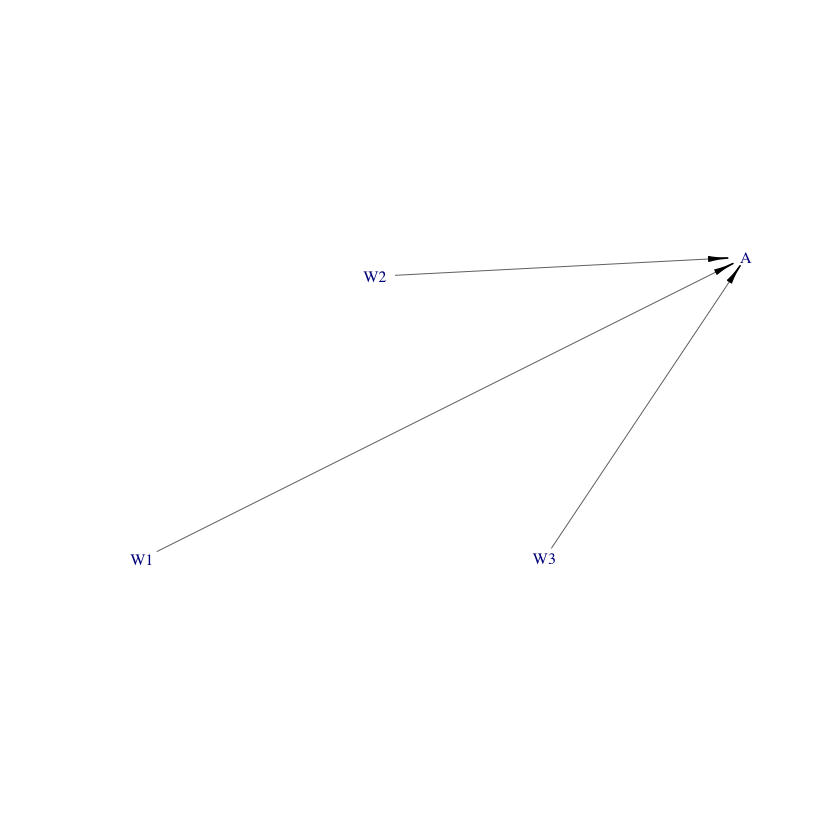

In [4]:
plotDAG(D, xjitter = 0.3, yjitter = 0.04, edge_attrs = list(width = 0.5, arrow.width = 0.4, arrow.size = 0.8), vertex_attrs = list(size = 12, label.cex = 0.8))

Now that we've taken a look at the structure of the data-generating process (the DAG), let's generate some data and take a quick look at the data set:

In [5]:
data_O <- as.data.table(sim(D, n = 10000, rndseed = 57192))
head(data_O)

simulating observed dataset from the DAG object


ID,W1,W2,W3,A
1,0,0,0,0.264097302
2,1,0,1,1.947282783
3,1,0,0,0.343522286
4,0,0,0,-1.342266575
5,0,0,0,1.446429830
6,0,0,0,-0.001315845


In [6]:
newdata <- data_O[sample(seq_len(1000)), c("W1", "W2", "W3", "A"), with = FALSE]

Now that we've generate some data, we will generate an `Task` object for use with `sl3`:

In [7]:
task <- sl3_Task$new(data_O, covariates = c("W1", "W2", "W3"),
                     outcome = "A")
task

A sl3 Task with 10000 obs and these nodes:
$covariates
[1] "W1" "W2" "W3"

$outcome
[1] "A"

$id
NULL

$weights
NULL

$offset
NULL


We'll do this same conversion for the sub-sampled testing data as well:

In [8]:
new_task <- sl3_Task$new(newdata, covariates = c("W1", "W2", "W3"),
                         outcome = "A")

In [13]:
sl3::sl3_list_properties()

[1] "binomial"             "categorical"          "continuous"          
 [4] "density"              "ids"                  "multivariate_outcome"
 [7] "offset"               "preprocessing"        "timeseries"          
[10] "weights"              "wrapper"

In [14]:
lrn <- Lrnr_condensier$new(nbins = 10, bin_method = "equal.len", 
  bin_estimator = Lrnr_xgboost$new(nrounds = 50, objective = "reg:logistic"))

In [15]:
trained_lrn = lrn$train(task)
pred_probs = trained_lrn$predict(new_task)
head(pred_probs)

likelihood
0.1054223
0.3310383
0.3310383
0.1044063
0.1429661
0.1044063


Next, ...

In [16]:
lrn1 <- Lrnr_condensier$new(nbins = 25, bin_method = "equal.len", 
  bin_estimator = Lrnr_glm_fast$new())
lrn2 <- Lrnr_condensier$new(nbins = 35, bin_method = "equal.len",
  bin_estimator = Lrnr_xgboost$new(nrounds = 50, objective = "reg:logistic"))

In [19]:
sl <- Lrnr_sl$new(learners = list(lrn1, lrn2),
                  metalearner = Lrnr_solnp_density$new())
sl_fit <- sl$train(task)
head(sl_fit$predict(new_task))


Iter: 1 fn: 17575.2858	 Pars:  0.38205 0.61795
Iter: 2 fn: 17575.2858	 Pars:  0.38205 0.61795
solnp--> Completed in 2 iterations

density meta-learner fit:
Lrnr_condensier_equal.len_25_20_FALSE_NA_FALSE_NULL 
                                          0.3820534 
Lrnr_condensier_equal.len_35_20_FALSE_NA_FALSE_NULL 
                                          0.6179466 


likelihood
0.15692777
0.32778128
0.29269600
0.13861217
0.21158060
0.04837965


In [18]:
?Lrnr_solnp_density

Lrnr_solnp_density {sl3},R Documentation


### Nesting the Super Learner for bin hazards with density Super Learner

Note that bin_estimator can be also a Super-Learner object from sl3. In this case the bin hazard will be estimated by stacking several candidate estimators. For example, below, we define a single density learner lrn, with the hazard estimator defined by the Super-Learner that stacks two candidates (GLM and xgboost GBM). Note that in contrast to the above example, this Super-Learner fit will be optimized for the logistic regression problem (estimating pooled bin hazards), but still using internal 10-fold cross-validation.

In [20]:
lrn <- Lrnr_condensier$new(nbins = 35, bin_method = "equal.len", bin_estimator = 
  Lrnr_sl$new(
    learners = list(
      Lrnr_glm_fast$new(family = "binomial"),
      Lrnr_xgboost$new(nrounds = 50, objective = "reg:logistic")
      ),
    metalearner = Lrnr_glm$new()
    ))
binSL_fit <- lrn$train(task)
head(binSL_fit$predict(new_task))

likelihood
0.10960448
0.30398384
0.30398384
0.14400828
0.20825493
0.06986179


### Homwork #3: Using and contributing to `sl3`

What learners to contribute: https://github.com/tlverse/sl3/issues/114
How do learners work: https://sl3.tlverse.org/articles/custom_lrnrs.html

Tips and best practices:
* For the `sl3` repo from https://github.com/tlverse/sl3
* Using git, create a new branch for your proposed contribution (e.g., `Lrnr_ranger`)
* Generate a template for your new learner via `sl3::write_learner_template(here::here("R", "Lrnr_ranger.R"))`
* Fill out the template based on the properties of your new learner. Try looking at already written learners to get a better idea of how to fill out the various methods slots.
* Write a set of unit tests under `tests/testthat/test_Lrnr_ranger.R` that ensure that your new learner works as intended/expected.
* For a guide on how to write unit tests properly, try looking at the numerous unit tests that already exist inside the `sl3` package.
* For background on unit testing in R, take a look here: http://r-pkgs.had.co.nz/tests.html
* The `tlverse` ecosystem uses the ["`Tidyverse` Style Guide"](http://style.tidyverse.org/). Make sure to follow the formatting guidelines for your code and for pull requests. You can use the [`styler` R package](https://cran.r-project.org/web/packages/styler/index.html) to automatically reformat your code.